# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 50% от стоимости номера за одни сутки c учетом сезонного коэффициента и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

Импортируем необходимые для работы библиотеки:

<a id='import'></a>

In [1]:
import pandas as pd
from math import floor
import numpy as np
from tqdm import tqdm
import itertools
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.inspection import permutation_importance

plt.style.use('ggplot')
%matplotlib inline

Сохраним датасеты в переменные `hotel_train` и `hotel_test`:

In [2]:
hotel_train = pd.read_csv('hotel_train.csv')
hotel_test = pd.read_csv('hotel_test.csv')

In [3]:
hotel_train.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,0,1,2,3,4,5,6,7,8,9
is_canceled,0,0,0,0,1,1,1,0,0,0
lead_time,7.0,14.0,0.0,9.0,85.0,75.0,23.0,18.0,68.0,37.0
arrival_date_year,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0,0,0,0,0,0
stays_in_week_nights,1,2,2,2,3,3,4,4,4,4
adults,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [4]:
hotel_test.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,6086,6087,6088,6089,6090,6091,6092,6093,6094,6095
is_canceled,1,1,1,1,1,1,1,1,1,1
lead_time,74.0,62.0,62.0,71.0,172.0,52.0,143.0,21.0,89.0,48.0
arrival_date_year,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,January,January,January,January,January,January,January,January,January,January
arrival_date_week_number,1,1,1,1,1,1,1,1,1,1
arrival_date_day_of_month,1,1,1,1,1,1,2,2,2,2
stays_in_weekend_nights,1,2,2,2,2,2,1,1,1,1
stays_in_week_nights,0,2,2,2,5,5,1,3,3,4
adults,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0


Наполнение таблиц:

* id — номер записи;
* adults — количество взрослых постояльцев;
* arrival_date_year — год заезда;
* arrival_date_month — месяц заезда;
* arrival_date_week_number — неделя заезда;
* arrival_date_day_of_month — день заезда;
* babies — количество младенцев;
* booking_changes — количество изменений параметров заказа;
* children — количество детей от 3 до 14 лет;
* country — гражданство постояльца;
* customer_type — тип заказчика:
* Contract — договор с юридическим лицом;
* Group — групповой заезд;
* Transient — не связано с договором или групповым заездом;
* Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* days_in_waiting_list — сколько дней заказ ожидал подтверждения;
* distribution_channel — канал дистрибуции заказа;
* is_canceled — отмена заказа;
* is_repeated_guest — признак того, что гость бронирует номер второй раз;
* lead_time — количество дней между датой бронирования и датой прибытия;
* meal — опции заказа:
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
* previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
* previous_cancellations — количество отменённых заказов у клиента;
* required_car_parking_spaces — необходимость парковочных мест для автомобилей;
* reserved_room_type — тип забронированной комнаты;
* stays_in_weekend_nights — количество ночей в выходные дни;
* stays_in_week_nights — количество ночей в будние дни;
* total_nights — общее количество ночей;
* total_of_special_requests — количество специальных отметок.


### Шаг 2. Предобработка и исследовательский анализ данных

#### Первичное изучение данных

Выведем информацию о таблицах при помощи метода `info`:

In [5]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

#### Поиск дубликатов

Проверим таблицы на наличие явных дубликтов:

In [7]:
print(hotel_test.duplicated().mean())
print(hotel_train.duplicated().mean())

0.0
0.0


Явныt дубликаты отсутсвуют

Столбец `meal`:

In [8]:
print(hotel_train['meal'].nunique(), ":", hotel_train['meal'].unique())

5 : ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']


In [9]:
print(hotel_test['meal'].nunique(), ":", hotel_test['meal'].unique())

5 : ['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


Присутствуют неявные дубликаты из-за лишних пробелов

In [10]:
hotel_test['meal'] = hotel_test['meal'].str.strip()
hotel_train['meal'] = hotel_train['meal'].str.strip()

In [11]:
hotel_test['meal'].value_counts(normalize=True)

BB    0.761570
SC    0.163304
HB    0.074016
FB    0.001111
Name: meal, dtype: float64

In [12]:
hotel_train['meal'].value_counts(normalize=True)

BB    0.792546
HB    0.111791
SC    0.088749
FB    0.006914
Name: meal, dtype: float64

Столбец `reserved_room_type`:

In [13]:
print(hotel_train['reserved_room_type'].nunique(), ":", hotel_train['reserved_room_type'].unique())

7 : ['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']


In [14]:
print(hotel_test['reserved_room_type'].nunique(), ":", hotel_test['reserved_room_type'].unique())

7 : ['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


In [15]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

In [16]:
print(hotel_train['reserved_room_type'].unique())
print(hotel_train['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


#### Изменение типов данных

In [17]:
columns = ['lead_time', 'adults', 'children', 'babies']
hotel_test[columns] = hotel_test[columns].apply(pd.to_numeric, downcast='integer')
hotel_train[columns] = hotel_train[columns].apply(pd.to_numeric, downcast='integer')

In [18]:
hotel_test[columns].dtypes

lead_time    int16
adults        int8
children      int8
babies        int8
dtype: object

In [19]:
hotel_train[columns].dtypes

lead_time    int16
adults        int8
children      int8
babies        int8
dtype: object

#### Работа с выбросами

In [20]:
hotel_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,65229.0,NaN,NaN,NaN,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,NaN,NaN,NaN,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,NaN,NaN,NaN,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,NaN,NaN,NaN,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_month,65229,12,October,9255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,65229.0,NaN,NaN,NaN,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,NaN,NaN,NaN,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,NaN,NaN,NaN,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,NaN,NaN,NaN,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,NaN,NaN,NaN,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0


In [21]:
hotel_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,32412.0,NaN,NaN,NaN,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,NaN,NaN,NaN,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,NaN,NaN,NaN,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_year,32412.0,NaN,NaN,NaN,2017.0,0.0,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_month,32412,8,May,5262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,32412.0,NaN,NaN,NaN,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,NaN,NaN,NaN,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,NaN,NaN,NaN,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,NaN,NaN,NaN,2.34009,1.37517,0.0,1.0,2.0,3.0,6.0
adults,32412.0,NaN,NaN,NaN,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0


В таблицах присутствуют выбросы.
Столбец `lead_time` отвечает за количество дней между датой бронирования и датой прибытия(hotel_train):
* значения mean=`99.34` и median=`64` , 
* граница третьего квартиля=`151` ,
* максимальное значение=`374` (почти в 6 раз больше значения медианы)

Очевидно присутствуют выбросы в наборе данных

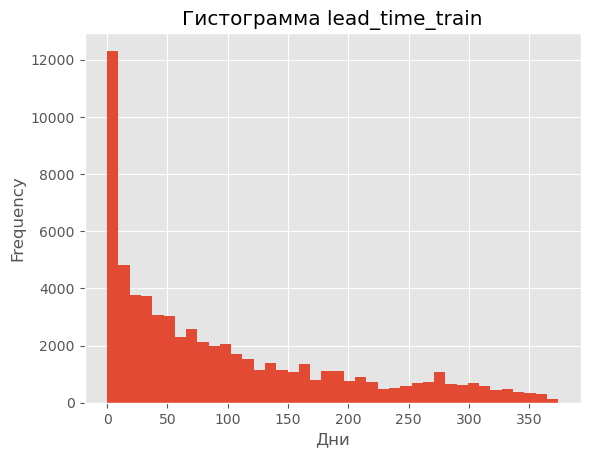

In [22]:
hotel_train['lead_time'].plot(kind='hist', bins=40, grid=True, title='Гистограмма lead_time_train')
plt.xlabel('Дни')
plt.show()

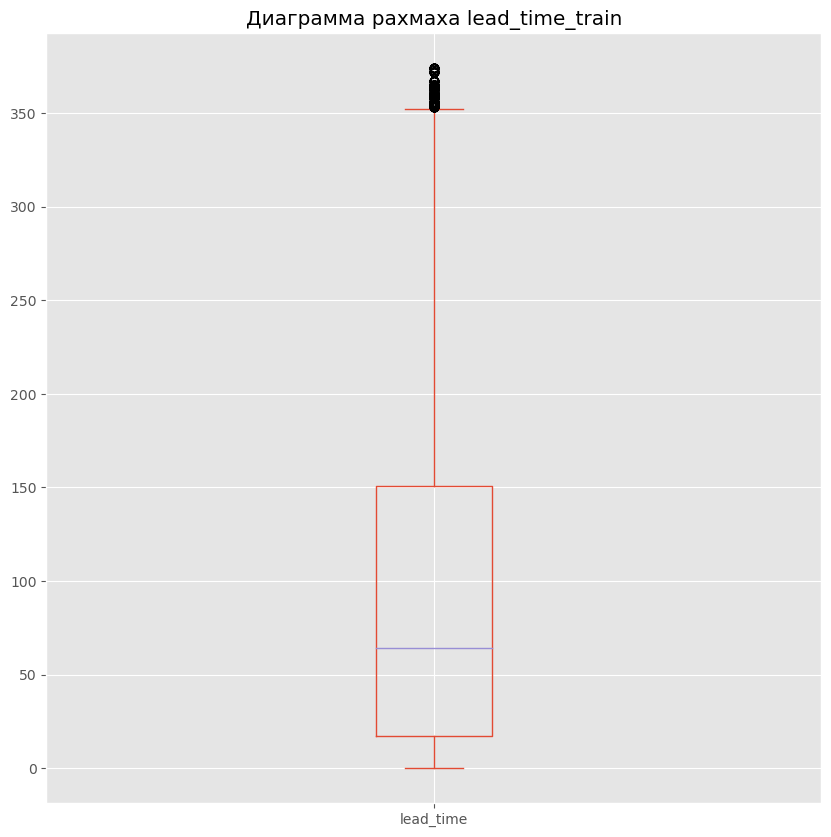

In [23]:
hotel_train['lead_time'].plot(kind='box',figsize=(10, 10), grid=True,  title='Диаграмма рахмаха lead_time_train');

In [24]:
print("Q3+k(Q3-Q1) =", hotel_train['lead_time'].quantile(0.75) + 1.5 * (hotel_train['lead_time'].quantile(0.75) - hotel_train['lead_time'].quantile(0.25)))
print("Кол-во записей (>352):", hotel_train.query('lead_time > 352')['lead_time'].count(), 
      ",",  round((hotel_train.query('lead_time > 352')['lead_time'].count() / hotel_train.shape[0]), 5))

Q3+k(Q3-Q1) = 352.0
Кол-во записей (>352): 493 , 0.00756


Верхняя граница диаграммы размаха равна `352`, данные превышающие данное значения можно принять за выбросы и убрать из данных, т.к. составляют менее 1 % от общего набора данных. Предполагаемая верхняя граница могла бы быть 365 - это означало, что люди могут бронировать номер за год до прибытия, но малое количетсво людей осуществляет бронь за год, а еще меньше людей реализуют ее.

In [25]:
hotel_train = hotel_train.query('lead_time <= 352')

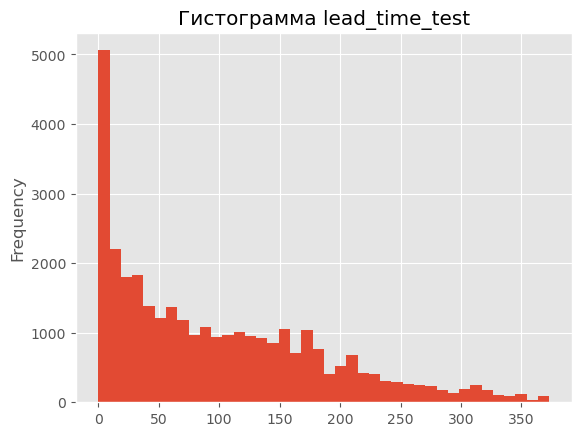

In [26]:
hotel_test['lead_time'].plot(kind='hist', bins=40, grid=True, title='Гистограмма lead_time_test');

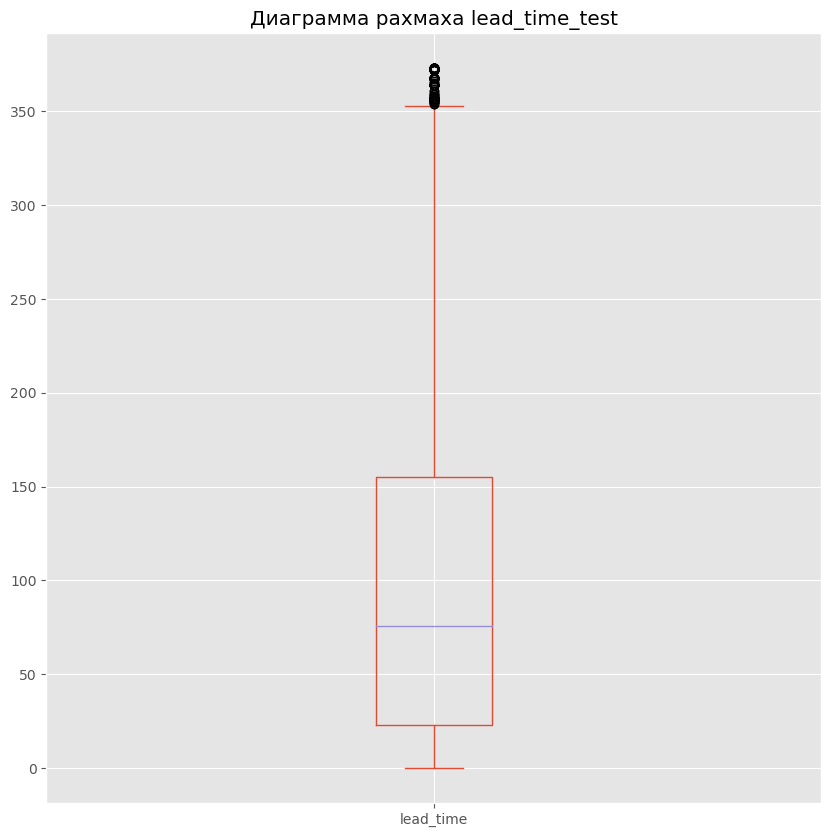

In [27]:
hotel_test['lead_time'].plot(kind='box',figsize=(10, 10), grid=True, legend=True, title='Диаграмма рахмаха lead_time_test');

In [28]:
print("Q3+k(Q3-Q1) =", hotel_test['lead_time'].quantile(0.75) + 1.5 * (hotel_test['lead_time'].quantile(0.75) - hotel_test['lead_time'].quantile(0.25)))
print("Кол-во записей (>353):", hotel_test.query('lead_time > 353')['lead_time'].count(), 
      ",",  round((hotel_test.query('lead_time > 352')['lead_time'].count() / hotel_test.shape[0]), 5))

Q3+k(Q3-Q1) = 353.0
Кол-во записей (>353): 132 , 0.00435


In [29]:
hotel_test = hotel_test.query('lead_time <= 353')

Cтолбец `adults`

Кол-во взрослых, значение `0` не может присутствовать в данных, т.к. это невозможно

In [30]:
hotel_train = hotel_train.query('adults!=0')
hotel_test = hotel_test.query('adults!=0')

Столбец `babies`

Кол-во детей, значения от 9 возможны, но cкорее всего являются ошибочными, считаем их выбросами (состааляют менее 1 % в данных)

In [31]:
print(hotel_train['babies'].value_counts(normalize=True))
print(hotel_test['babies'].value_counts(normalize=True))

0     0.993062
1     0.006861
2     0.000046
10    0.000015
9     0.000015
Name: babies, dtype: float64
0    0.994567
1    0.005309
2    0.000124
Name: babies, dtype: float64


In [32]:
hotel_train = hotel_train.query('babies < 9')

Столбец `required_car_parking_spaces`

Необходимость парковочных(ого) мест(а) для автомобилей(я). Более 2 мест возможно, если приезжают группой, но маловерятно. Значения 2, 3, 8 можно посчитать выбросами (составляют менее 1 % данных)

In [33]:
print(hotel_test['required_car_parking_spaces'].value_counts(normalize=True))
print(hotel_train['required_car_parking_spaces'].value_counts(normalize=True))                       

0    0.954208
1    0.045512
2    0.000186
8    0.000062
3    0.000031
Name: required_car_parking_spaces, dtype: float64
0    0.943192
1    0.056622
2    0.000170
3    0.000015
Name: required_car_parking_spaces, dtype: float64


In [34]:
hotel_train = hotel_train.query('required_car_parking_spaces < 2')
hotel_test = hotel_test.query('required_car_parking_spaces < 2')

Таблица `booking_changes`

Кол-во изменений параметров заказа. 

In [35]:
hotel_train['booking_changes'].value_counts(normalize=True)

0     0.862104
1     0.101183
2     0.026783
3     0.006103
4     0.002277
5     0.000635
6     0.000279
7     0.000263
8     0.000108
9     0.000077
13    0.000062
10    0.000031
14    0.000031
15    0.000031
16    0.000015
17    0.000015
Name: booking_changes, dtype: float64

In [36]:
hotel_test['booking_changes'].value_counts(normalize=True)

0     0.856251
1     0.094342
2     0.035774
3     0.008291
4     0.003633
5     0.000870
6     0.000466
7     0.000155
18    0.000031
15    0.000031
16    0.000031
14    0.000031
8     0.000031
11    0.000031
10    0.000031
Name: booking_changes, dtype: float64

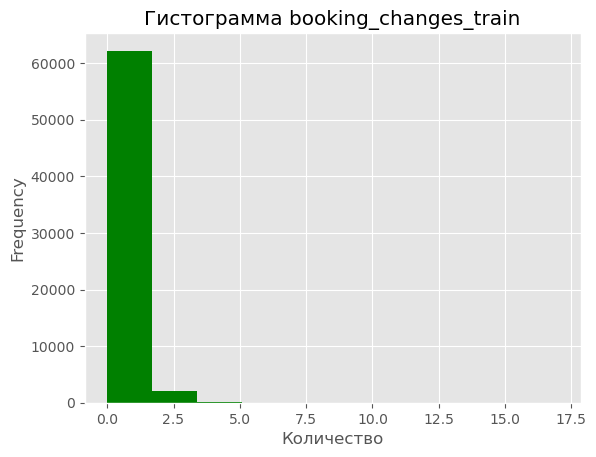

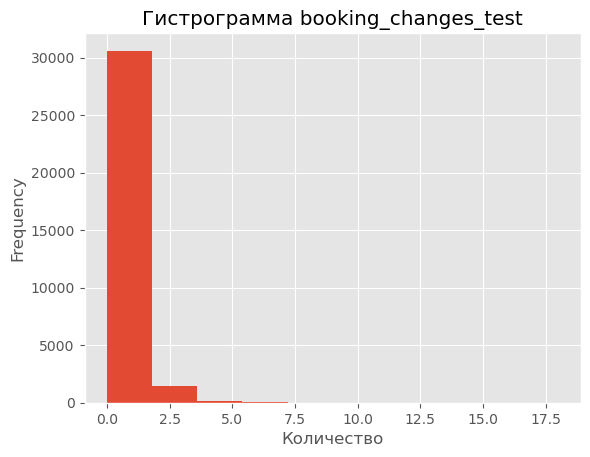

In [37]:
hotel_train['booking_changes'].plot(kind='hist', color='green',grid=True, title='Гистограмма booking_changes_train')
plt.xlabel('Количество')
plt.show()

hotel_test['booking_changes'].plot(kind='hist', grid=True, title='Гистрограмма booking_changes_test')
plt.xlabel('Количество')
plt.show()

In [38]:
hotel_train = hotel_train.query('booking_changes <= 5')
hotel_test = hotel_test.query('booking_changes <= 6')

Столбец `days_in_waiting_list`

Кол-во дней ожидания потворждения заказа. 

In [39]:
hotel_train['days_in_waiting_list'].value_counts(normalize=True)

0      0.950029
39     0.002868
58     0.002543
44     0.002124
31     0.001954
         ...   
14     0.000016
76     0.000016
81     0.000016
74     0.000016
167    0.000016
Name: days_in_waiting_list, Length: 97, dtype: float64

In [40]:
hotel_test['days_in_waiting_list'].value_counts(normalize=True)

0      0.994532
60     0.000186
59     0.000186
25     0.000186
71     0.000186
         ...   
76     0.000031
47     0.000031
165    0.000031
111    0.000031
98     0.000031
Name: days_in_waiting_list, Length: 74, dtype: float64

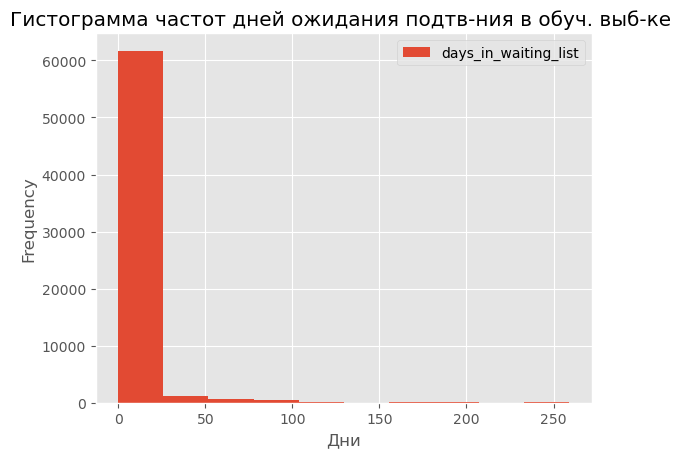

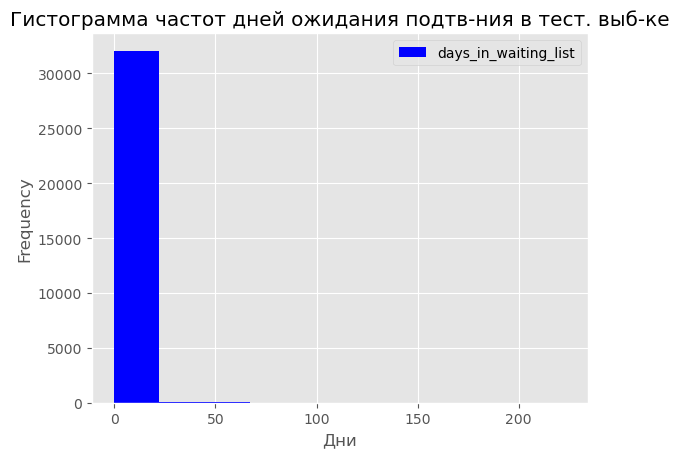

In [41]:
hotel_train['days_in_waiting_list'].plot(kind='hist', bins=10, grid=True, legend=True, title='Гистограмма частот дней ожидания подтв-ния в обуч. выб-ке ')
plt.xlabel('Дни')
plt.show()

hotel_test['days_in_waiting_list'].plot(kind='hist', bins=10, color='blue', grid=True, legend=True, title='Гистограмма частот дней ожидания подтв-ния в тест. выб-ке')
plt.xlabel('Дни')
plt.show()

In [42]:
hotel_train = hotel_train.query('days_in_waiting_list <= 71')
hotel_test = hotel_test.query('days_in_waiting_list <= 71')

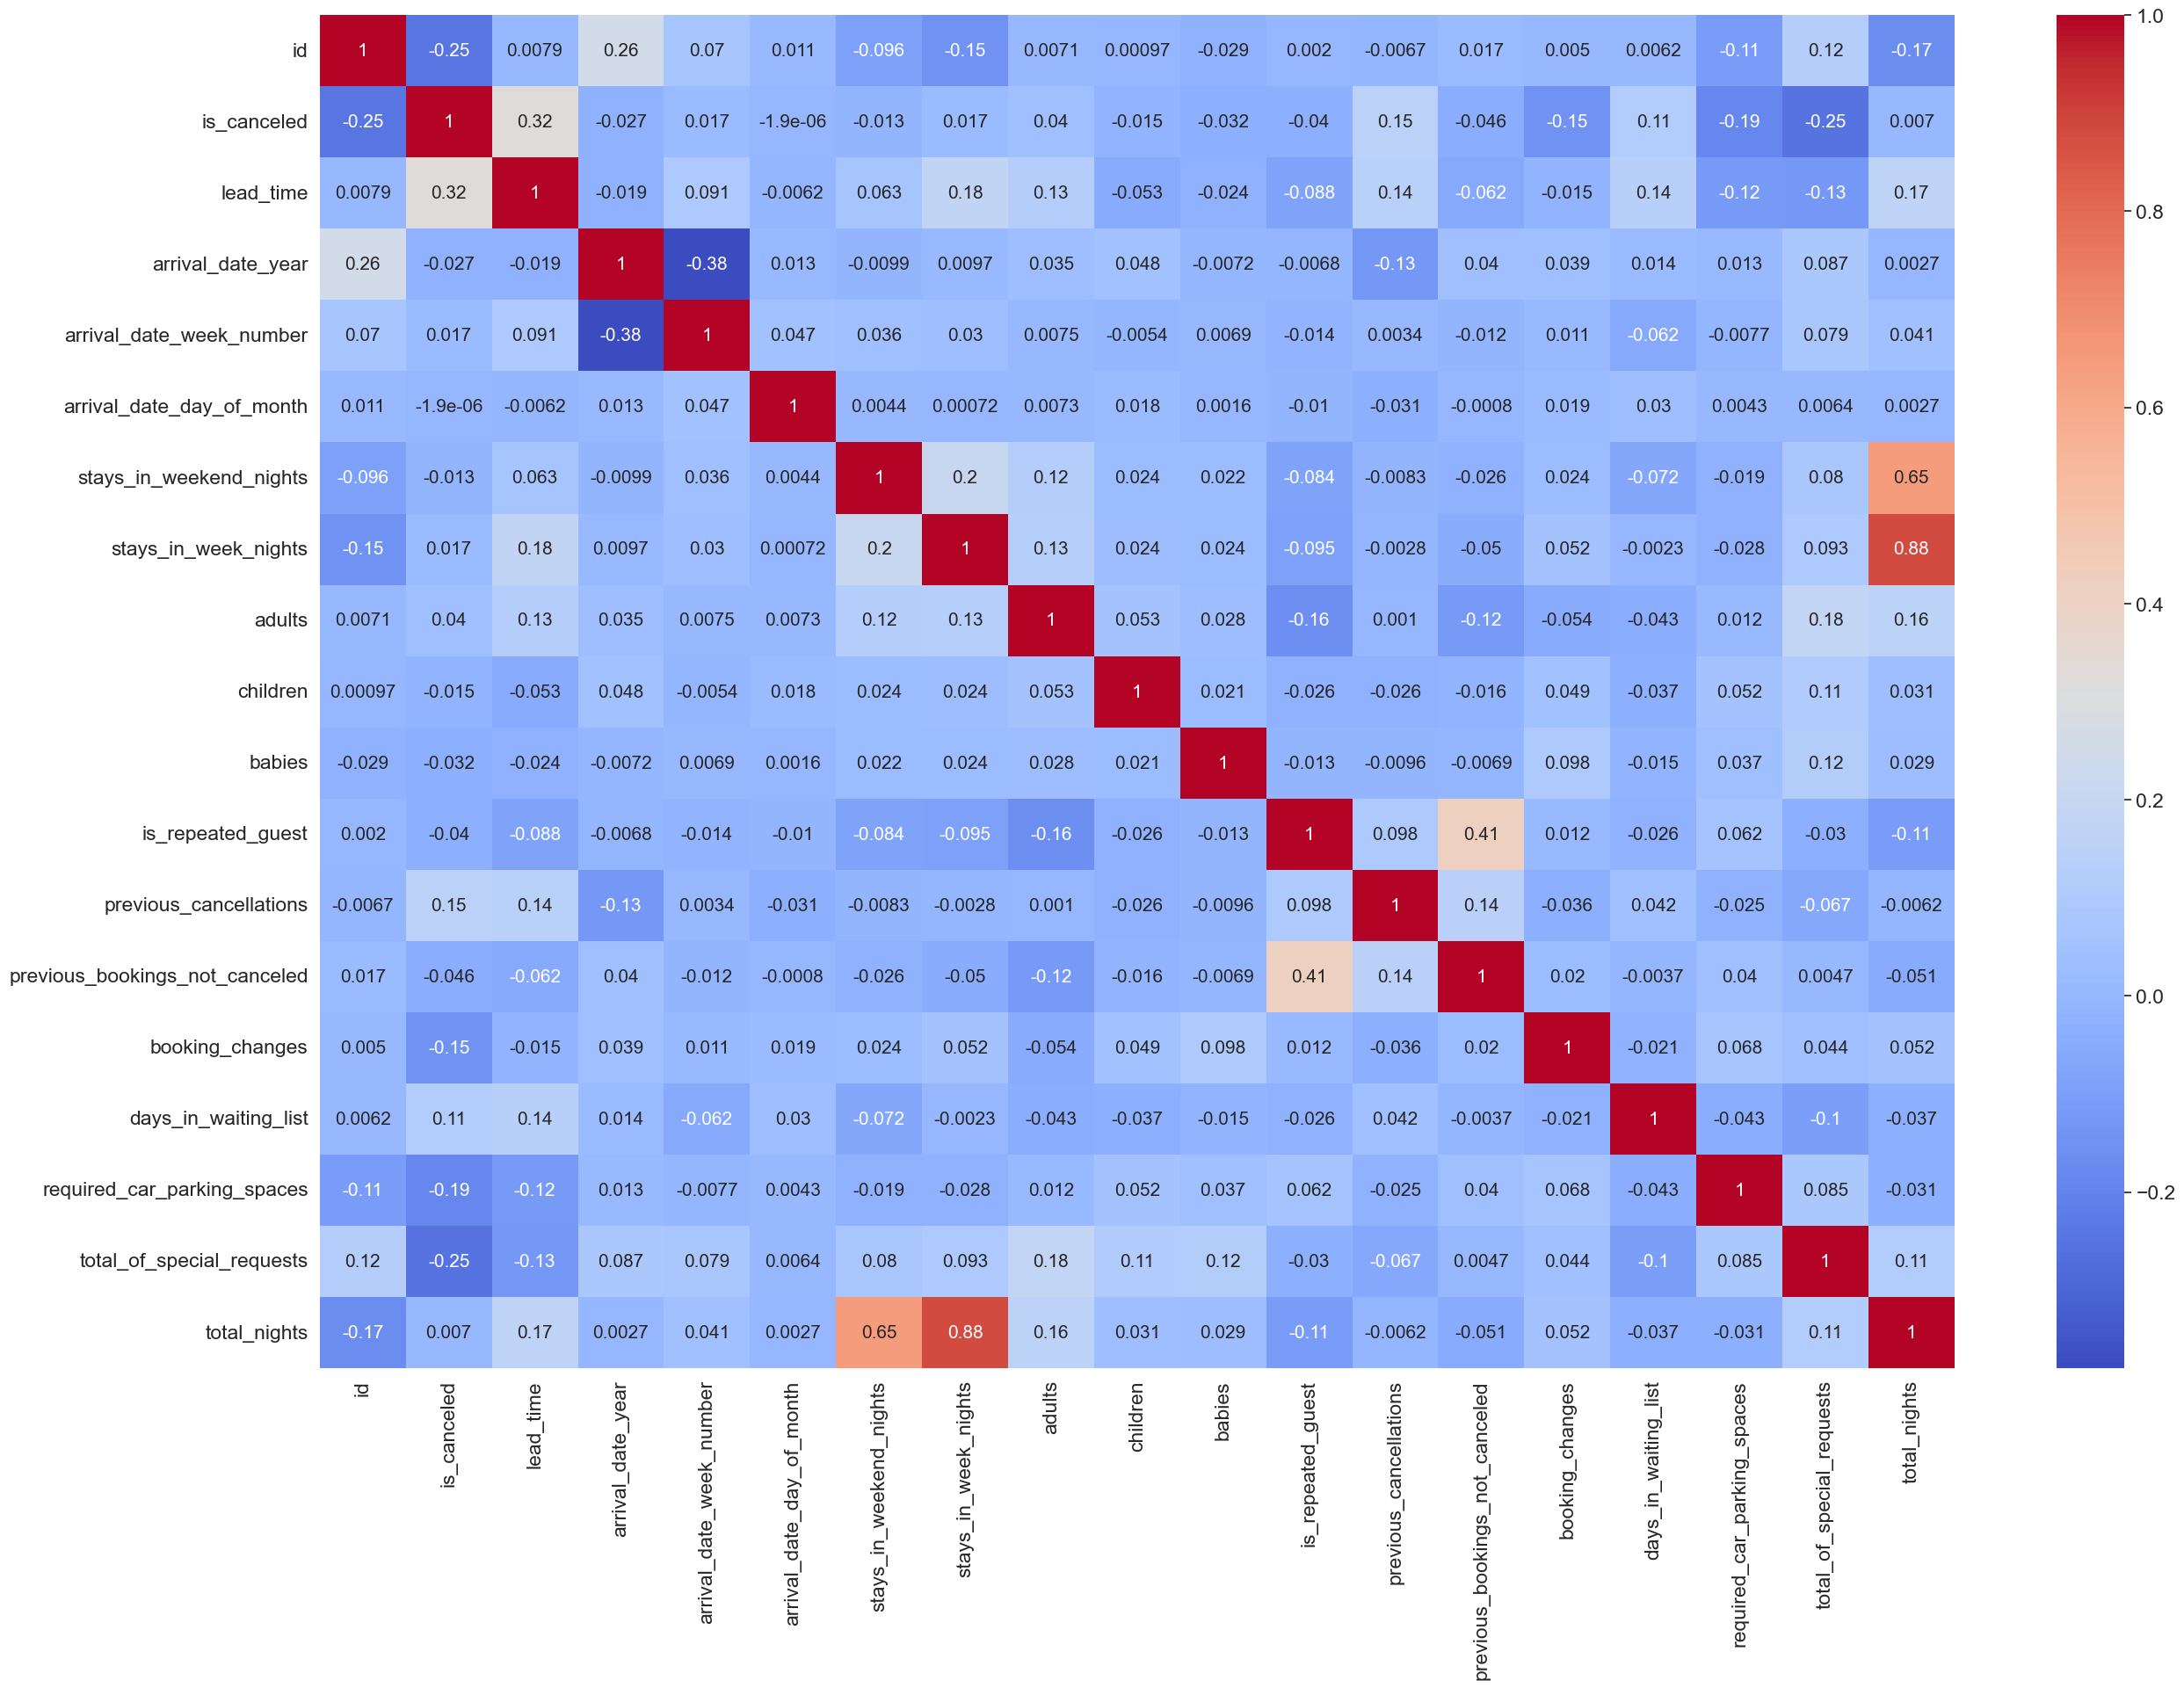

In [43]:
plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
sns.heatmap(hotel_train.corr(), annot=True, fmt='.2g', cmap= 'coolwarm', annot_kws={"fontsize":15});

Из матрицы видно следующие зависимости:
* stays_in_weekend_nights - total_nights = `0.65` | Заметная связь
* stays_in_week_nights - total_nights = `0.88` | Высокая связь

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

##### `Cтоимость номеров отеля` | Категория номера : Стоимость проживания за ночь : Стоимость разового обслуживания 

In [44]:
columns = ['room_category', 'сost_per_night', 'room_service']
data = [['A', 1000, 400], ['B', 800, 350], ['C', 600, 350],
        ['D', 550, 150], ['E', 500, 150], ['F', 450, 150], ['G', 350, 150]]

hotel_room_cost = pd.DataFrame(data=data, columns = columns)
display(hotel_room_cost)

,room_category,сost_per_night,room_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [45]:
summer = [['June', 'July', 'August']]
winter = [['December', 'January', 'February']]

In [46]:
def profit_without_deposit(features):
    room_type = features['reserved_room_type']
    price_night = hotel_room_cost[hotel_room_cost['room_category'] == room_type]['сost_per_night'].values[0]
    price_service = hotel_room_cost[hotel_room_cost['room_category'] == room_type]['room_service'].values[0]
    nights = features['total_nights'] 
    month_arrival = features['arrival_date_month']
    
    if features['is_canceled'] == 0:
        if nights > 3:
            amount_service = nights
        else:
            amount_service = floor(nights / 2)
        if month_arrival in summer:
            profit = 1.4 * price_night * nights - amount_service * price_service
        elif month_arrival in winter:
            profit = price_night * nights - amount_service * price_service
        else:
            profit = 1.2 * price_night * nights - amount_service * price_service
    else:    
        if month_arrival in summer:
            profit = -(1.4 * price_night + price_service)
        elif month_arrival in winter:
            profit = -(price_night + price_service)
        else:
            profit = -(1.2 * price_night + price_service)
    
    return profit

In [47]:
profit_less_deposit = hotel_test.apply(profit_without_deposit, axis=1).sum()
print(f'Прибыль отеля без внедрения депозита = {profit_less_deposit}')

Прибыль отеля без внедрения депозита = 31638660.0


#### Вывод

Прибыль составляет `31,6` млн рублей

### Шаг 4. Разработка модели ML

Стобец `is_canceled` - означающий отмену брони. Необходимо определить будет ли совершена отмена брони.

В качестве признаков будем использовать следующие столбцы, которые на наш взгляд могут повлиять на принятие решения об отмене брони: 
`adults`, `arrival_date_week_number`, `babies`, `country`, `children`, `customer_type`, `days_in_waiting_list`, `is_repeated_guest`, `lead_time`, `meal`, `previous_bookings_not_canceled`, `previous_cancellations`, `required_car_parking_spaces`, `reserved_room_type`, `stays_in_weekend_nights`, `stays_in_week_nights`, `total_of_special_requests`, `booking_changes`.

Целевой признак `is_canceled`.

In [48]:
SEED = 12345

In [49]:
columns_drop = ['id', 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'distribution_channel', 'total_nights']

hotel_train_ohe = hotel_train.drop(columns_drop, axis=1)
hotel_test_ohe = hotel_test.drop(columns_drop, axis=1)

In [50]:
target_train = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']
features_train = hotel_train_ohe.drop('is_canceled', axis=1)
features_test = hotel_test_ohe.drop('is_canceled', axis=1)

Столбцы `customer_type` и `meal` - категориальные, их необходимо преобразовать в количественные.

In [51]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(features_train)
features_train = enc.transform(features_train) 
features_test = enc.transform(features_test)

Модель `Логистическая регрессия`

In [52]:
model_log_reg = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced')
scores_log_reg = cross_val_score(model_log_reg, features_train, target_train, scoring='f1')
print(f'Средняя оценка качества модели = {round(scores_log_reg.mean(), 5)}')

Средняя оценка качества модели = 0.54064


Модель `Дерево решений`

In [53]:
model = DecisionTreeClassifier(random_state=SEED)
params_tree = {
    'max_depth' : np.arange(1, 15, 1),
    'min_samples_leaf' : np.arange(1, 5),
    'class_weight' : ['balanced']
}
gs_tree = GridSearchCV(model, params_tree, scoring='f1', cv=5)
gs_tree.fit(features_train, target_train)

print('Max depth =', gs_tree.best_params_.get('max_depth'), '; '
      'Min samples leaf =', gs_tree.best_params_.get('min_samples_leaf'))
print('F1-score = ', round(gs_tree.best_score_, 5))

Max depth = 5 ; Min samples leaf = 1
F1-score =  0.65536


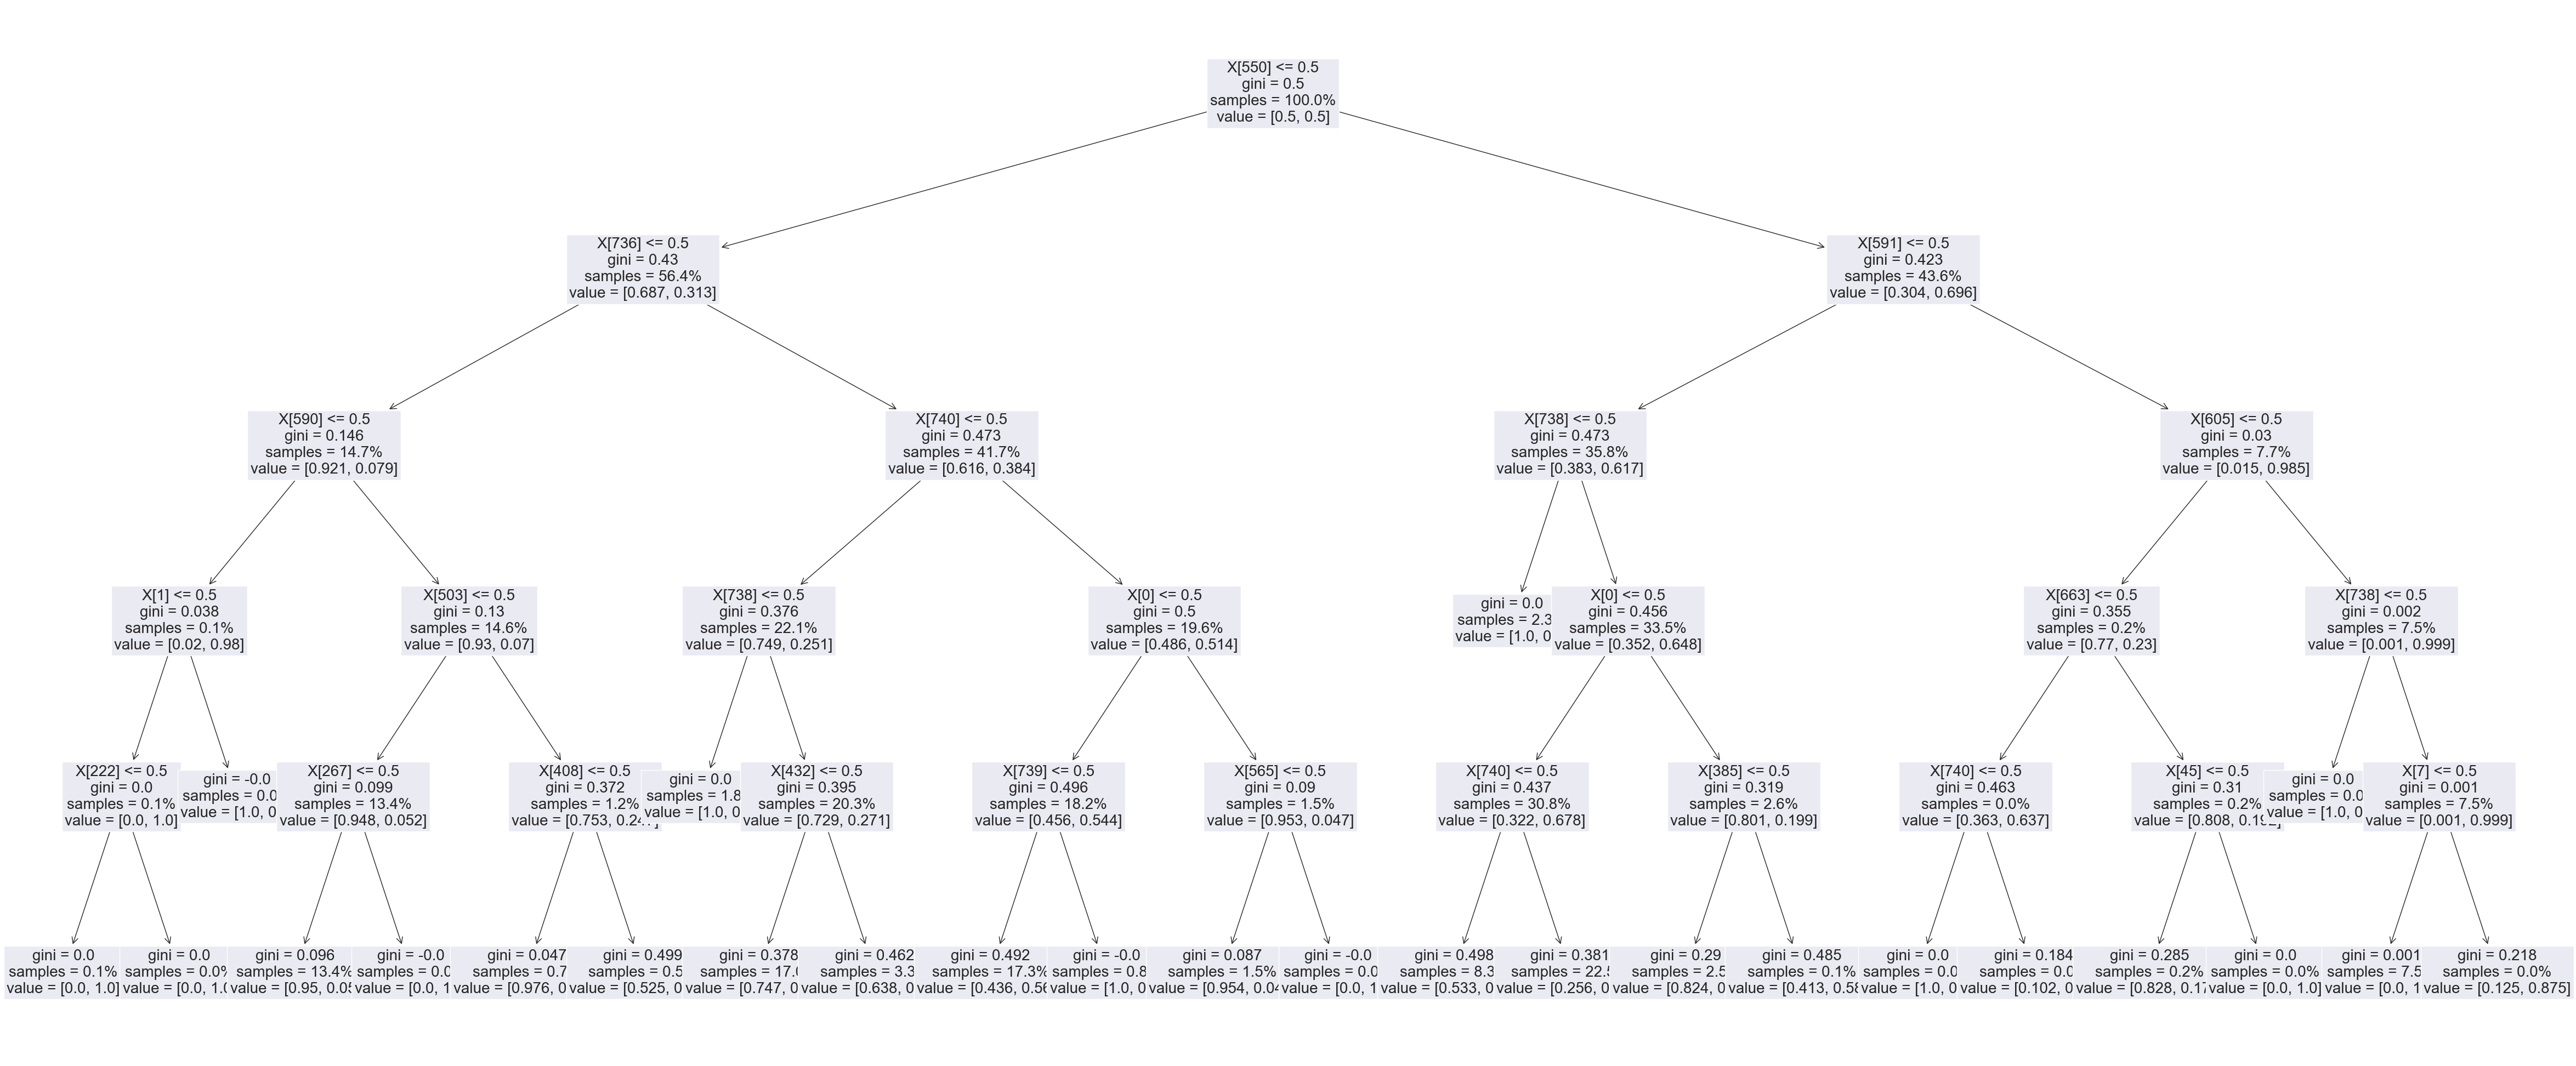

In [54]:
fig, ax = plt.subplots(figsize=(60, 25))
model_tree = DecisionTreeClassifier(random_state=SEED, max_depth=gs_tree.best_params_.get('max_depth'), class_weight='balanced')
model_tree.fit(features_train, target_train)
tree.plot_tree(model_tree, proportion=True, fontsize=20)
plt.show()

Модель `Случайного леса`

In [55]:
model = RandomForestClassifier(random_state=SEED)
params_forest= {
    'n_estimators' : np.arange(1, 51, 5),
    'max_depth' : np.arange(1, 3),
    'class_weight': ['balanced']
}
gs_forest= GridSearchCV(model, params_forest, scoring='f1', cv=5)
gs_forest.fit(features_train, target_train)

print('Estimators =', gs_forest.best_params_.get('n_estimators'), '; '
      'Max depth =', gs_forest.best_params_.get('max_depth'))
print('F1-score = ', round(gs_forest.best_score_, 5))

Estimators = 46 ; Max depth = 2
F1-score =  0.6458


Посмотрим как покажут себя модели на тестовых данных.

Модель `Дерево решений`

Значение F1-меры на тестовой выборке = 0.6346
Значение метрики AUC-ROC = 0.77513


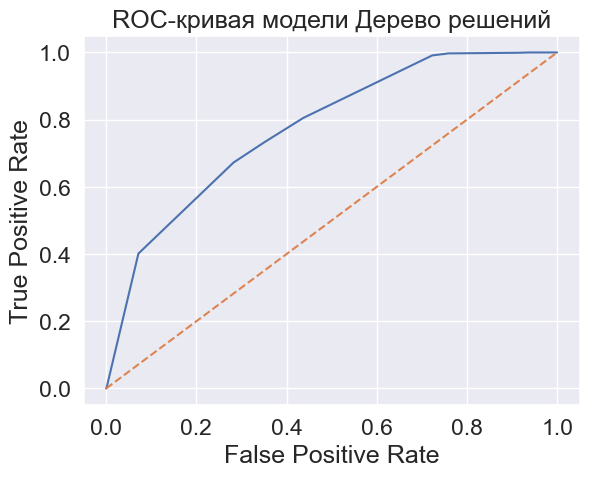

In [56]:
model =  DecisionTreeClassifier(random_state=SEED, max_depth=gs_tree.best_params_.get('max_depth'), class_weight='balanced')
model.fit(features_train, target_train)

predicted_test = model_tree.predict(features_test)
probabilities_test = model_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
f1_score_tree = f1_score(target_test, predicted_test)
auc_roc_tree = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

print(f'Значение F1-меры на тестовой выборке = {round(f1_score_tree, 5)}') 
print(f'Значение метрики AUC-ROC = {round(auc_roc_tree, 5)}')

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели Дерево решений')
plt.show()

Модель `Случайный лес`

Значение F1-меры на тестовой выборке = 0.67673
Значение метрики AUC-ROC = 0.81477


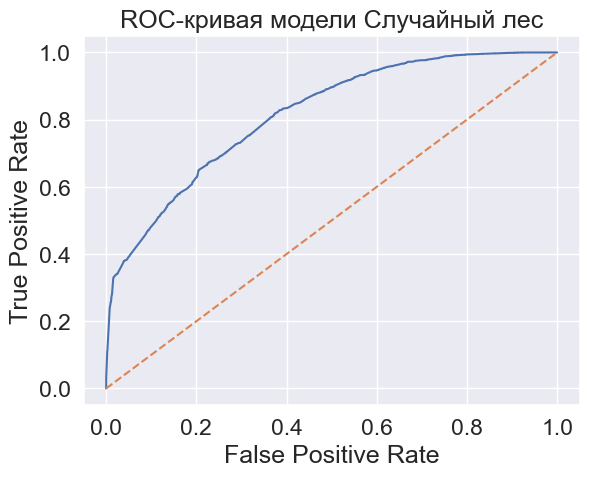

In [57]:
model_forest = RandomForestClassifier(random_state=SEED, n_estimators=gs_forest.best_params_.get('n_estimators'),
                              max_depth=gs_forest.best_params_.get('max_depth'), class_weight='balanced')
model_forest.fit(features_test, target_test)
predicted_test = model_forest.predict(features_test)
probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
f1_score_forest = f1_score(target_test, predicted_test)
auc_roc_forest = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

print(f'Значение F1-меры на тестовой выборке = {round(f1_score_forest, 5)}') 
print(f'Значение метрики AUC-ROC = {round(auc_roc_forest, 5)}')

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели Случайный лес')
plt.show()

In [58]:
hotel_test['predictions'] = predicted_test
display(hotel_test.T)
display(hotel_test['predictions'].value_counts(normalize=True))

,0,1,2,3,4,5,6,7,8,9,...,32402,32403,32404,32405,32406,32407,32408,32409,32410,32411
id,6086,6087,6088,6089,6090,6091,6092,6093,6094,6095,...,97894,97895,97896,97897,97898,97899,97900,97901,97902,97903
is_canceled,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
lead_time,74,62,62,71,172,52,143,21,89,48,...,185,247,109,44,188,164,21,23,34,109
arrival_date_year,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,January,January,January,January,January,January,January,January,January,January,...,August,August,August,August,August,August,August,August,August,August
arrival_date_week_number,1,1,1,1,1,1,1,1,1,1,...,35,35,35,35,35,35,35,35,35,35
arrival_date_day_of_month,1,1,1,1,1,1,2,2,2,2,...,30,31,31,31,31,31,30,30,31,31
stays_in_weekend_nights,1,2,2,2,2,2,1,1,1,1,...,1,1,1,1,2,2,2,2,2,2
stays_in_week_nights,0,2,2,2,5,5,1,3,3,4,...,4,3,3,3,3,4,5,5,5,5
adults,2,2,2,1,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


1    0.535888
0    0.464112
Name: predictions, dtype: float64

Посчитаем прибыль с учетом внедренной системы депозита:

In [59]:
def profit_with_deposit(features):
    room_type = features['reserved_room_type']
    price_night = hotel_room_cost[hotel_room_cost['room_category'] == room_type]['сost_per_night'].values[0]
    price_service = hotel_room_cost[hotel_room_cost['room_category'] == room_type]['room_service'].values[0]
    nights = features['total_nights'] 
    month_arrival = features['arrival_date_month']
    
    if features['predictions'] == 1:
        if month_arrival in summer:
            deposit = 0.5 * (1.4 * price_night + price_service)
        elif month_arrival in winter:
            deposit = 0.5 * (price_night + price_service)
        else:
            deposit = 0.5 * (1.2 * price_night + price_service)
    else:
        deposit = 0
    
    if features['is_canceled'] == 0:
        if nights > 3:
            amount_service = nights
        else:
            amount_service = floor(nights / 2)
        if month_arrival in summer:
            profit = 1.4 * price_night * nights - amount_service * price_service
        elif month_arrival in winter:
            profit = price_night * nights - amount_service * price_service
        else:
            profit = 1.2 * price_night * nights - amount_service * price_service
    else:    
        if month_arrival in summer:
            profit = deposit - (1.4 * price_night + price_service)
        elif month_arrival in winter:
            profit = deposit - (price_night + price_service)
        else:
            profit = deposit - (1.2 * price_night + price_service)
    
    return profit

In [60]:
profit_with = hotel_test.apply(profit_with_deposit, axis=1).sum()
print(f'Прибыль отеля после внедрения депозита = {profit_with}')

Прибыль отеля после внедрения депозита = 38888365.0


In [61]:
IMPLEMENTATION_COST = 400000
profit_deposit =  profit_with- profit_less_deposit - IMPLEMENTATION_COST
print(f'Чистая прибыль после внедрения депозита с учетом всех расходом: {profit_deposit}')

Чистая прибыль после внедрения депозита с учетом всех расходом: 6849705.0


### Вывод

1. Прибыль отеля до внедрения системы депозитов: `31.6` млн. рублей
2. Модель `Дерево решений` на тестовой выборке: F1-score = `0.6346` | AUC_ROC = `0.77513`
3. Модель `Случайный лес` на тестовой выборке: F1-score = `0.67673` | AUC_ROC = `0.81477`
4. Система депозитов заключается в предоплате половины стоимости убытков отеля с учетом сезонного коэффиента при бронировании 
5. Прибыль отеля после внедрения систеы депозитов: `38.9` млн. рублей
6. Прибыль от внедрения системы депозитов с учетом расходов на внедрение системы составляет: `6.85` млн. рублей

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [62]:
hotel_test.query('is_canceled==1 and predictions==True').describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,10039.0,NaN,NaN,NaN,43287.581333,15829.477968,6086.0,45991.5,49085.0,52070.5,55280.0
is_canceled,10039.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
lead_time,10039.0,NaN,NaN,NaN,121.113557,81.392043,0.0,54.0,110.0,173.0,353.0
arrival_date_year,10039.0,NaN,NaN,NaN,2017.0,0.0,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_month,10039,8,May,1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,10039.0,NaN,NaN,NaN,18.03855,8.63176,1.0,11.0,18.0,24.0,35.0
arrival_date_day_of_month,10039.0,NaN,NaN,NaN,15.678852,8.703265,1.0,8.0,15.0,23.0,31.0
stays_in_weekend_nights,10039.0,NaN,NaN,NaN,0.848092,0.855659,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,10039.0,NaN,NaN,NaN,2.372946,1.286112,0.0,1.0,2.0,3.0,6.0
adults,10039.0,NaN,NaN,NaN,1.908955,0.416915,1.0,2.0,2.0,2.0,4.0


Проанализируем столбцы, содержащие категориальные переменные:

In [63]:
hotel_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True)

Transient          0.946011
Transient-Party    0.050005
Contract           0.003486
Group              0.000498
Name: customer_type, dtype: float64

В `96.4%` случаев не связан с договором или групповым заездом

In [64]:
hotel_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True)

BB    0.776372
SC    0.166550
HB    0.055782
FB    0.001295
Name: meal, dtype: float64

В `94.3%` случаев из доп. опций выбирают либо завтрак (`77.6%`) либо ничего (`16.7`)

In [65]:
hotel_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True)

A    0.807252
D    0.130292
E    0.035063
F    0.011953
G    0.008367
C    0.005877
B    0.001195
Name: reserved_room_type, dtype: float64

В `80.7%` случаев категория комнаты - А

In [66]:
hotel_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True)

TA/TO        0.918020
Direct       0.047714
Corporate    0.033171
GDS          0.001096
Name: distribution_channel, dtype: float64

В `91.8%` случаев канал дистрибуции - TA/TO

### Вывод

**1.** Бронирование в основном происходит за 110 дней до заезда

**2.** Заезд на 3 дня: 1 выходной и 2 будних дня

**3.** Новый клиент, не вносящий изменений в процессе

**4.** Двое взрослых без детей

**5.** Не требуется парковочное место

**6.** Категория номера - А (самая дорогая)

**7.** Из доп. опций либо завтак либо ничего

**8.** Не связан с договором либо групповым заездом

**9.** Канал дистрибуции - TA/TO